# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

### Introduction

* In this project, three models will be trained using Spacy, NLTK and LGBM in order to determine which model results in the best F1 score (at least .85) in detecting negative reviews in the dataset above. 
* The BERT model was not attempted in this notebook.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm
import re


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

There are a total of 4  missing values in the [average_rating] column and [votes] column. Since there is no wise way to fill them, I will just drop them from the dataset.

In [7]:
df_reviews= df_reviews.dropna()

In [8]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     0
votes              0
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

## EDA

Let's check the number of movies and reviews over years.

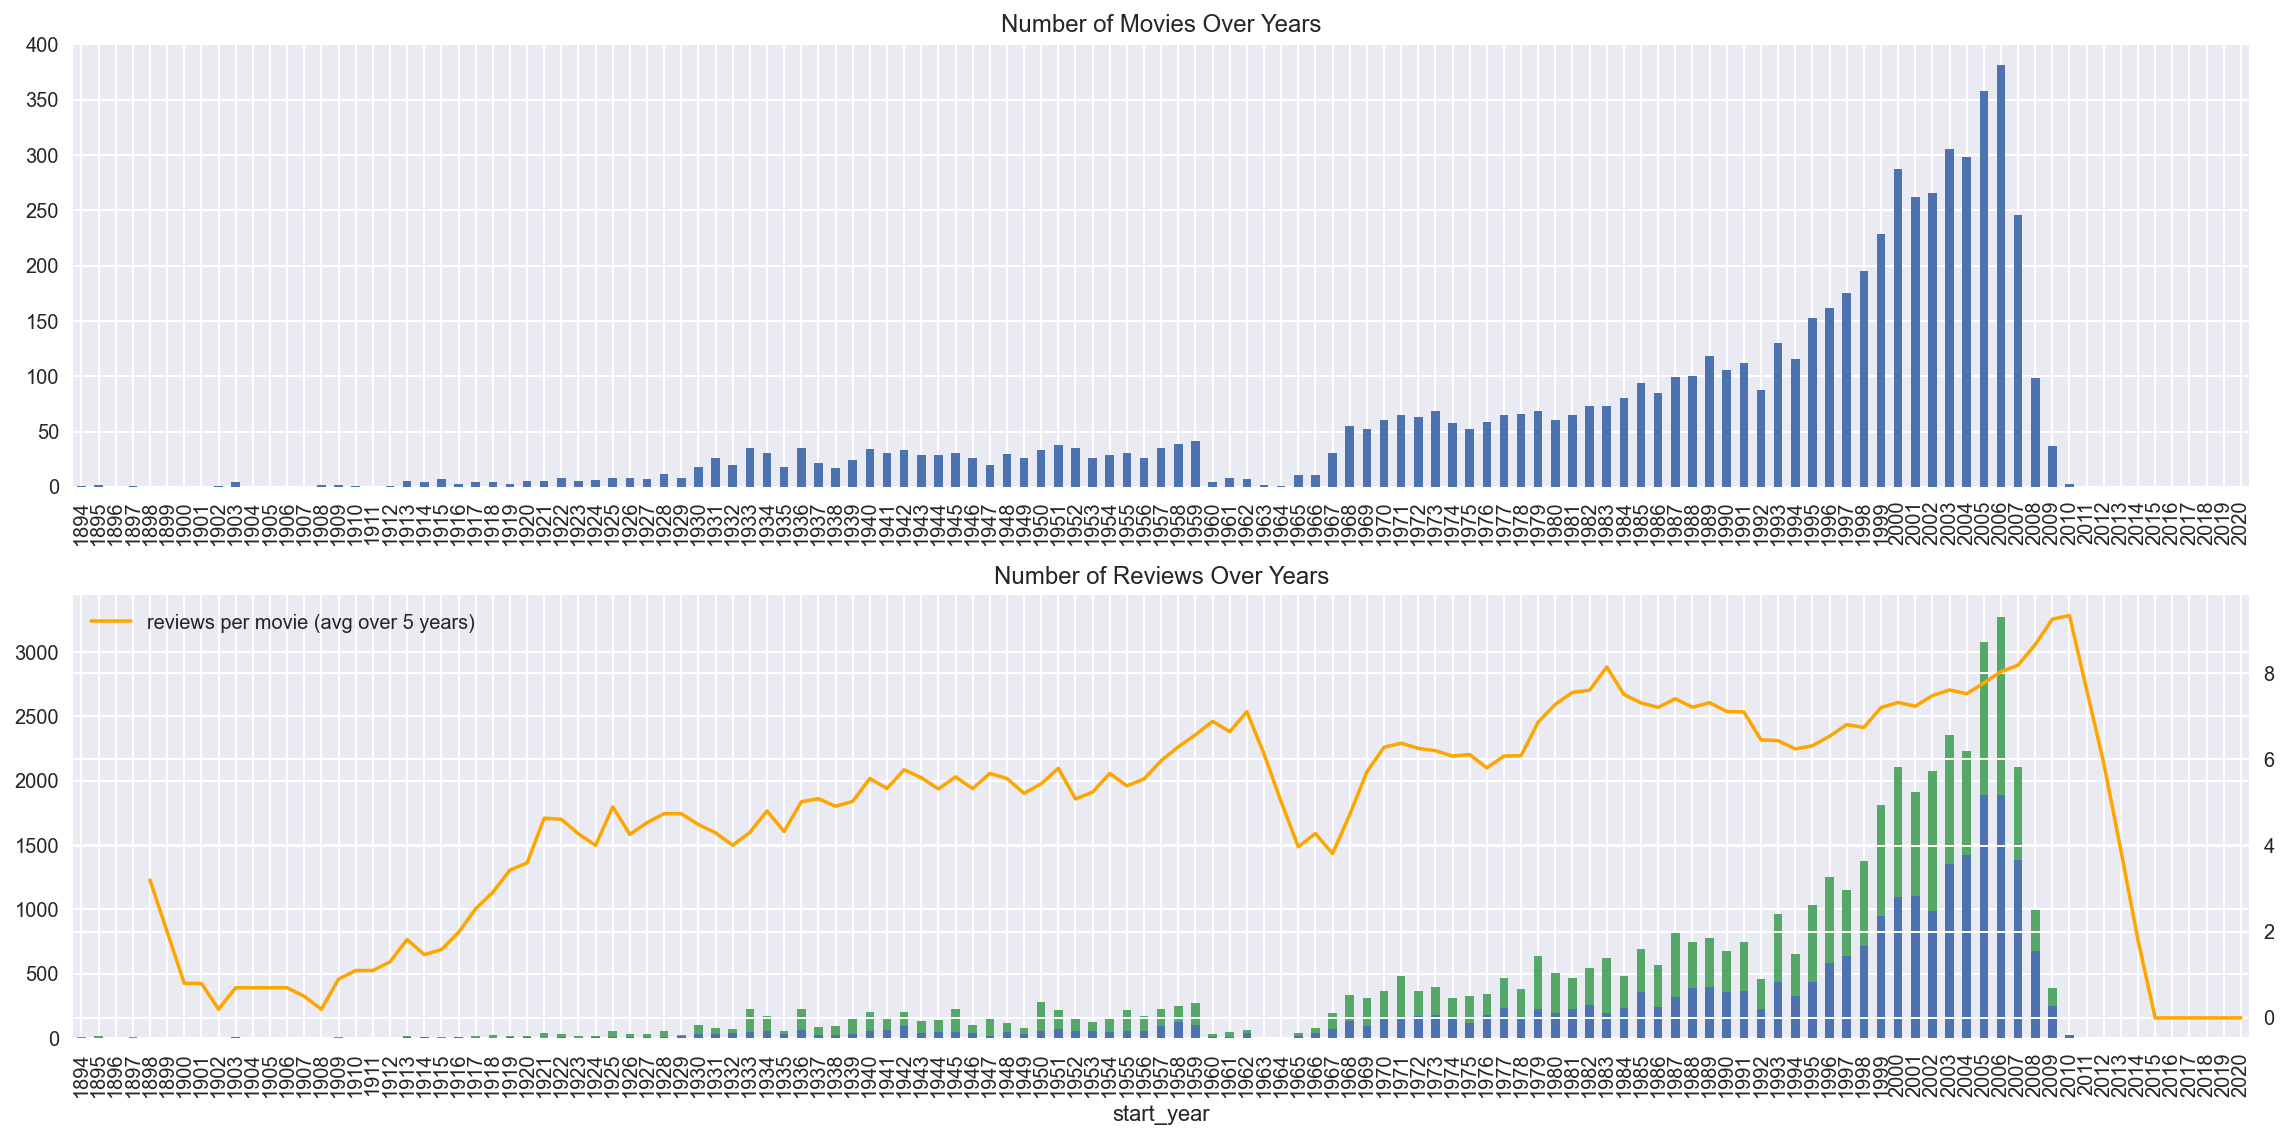

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

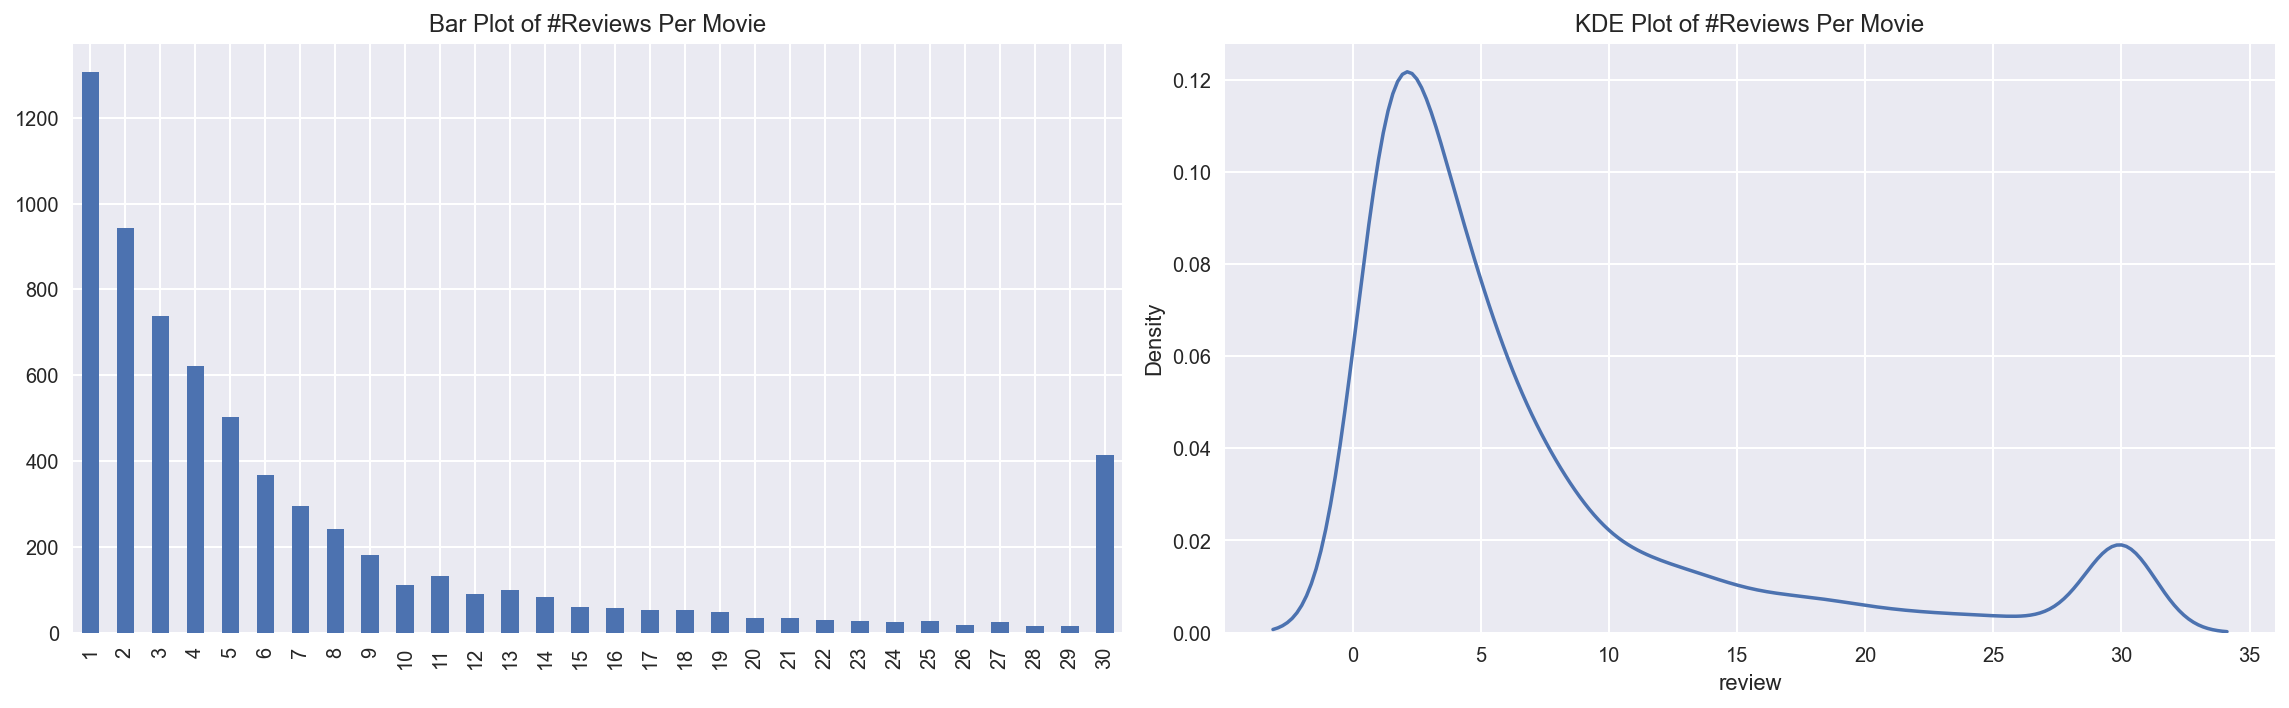

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

Most movies in the dataset have only 1-3 reviews 
There is another group of movies that have about 30 reviews each. 

In [11]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

The classes in the target here are pretty balanced.

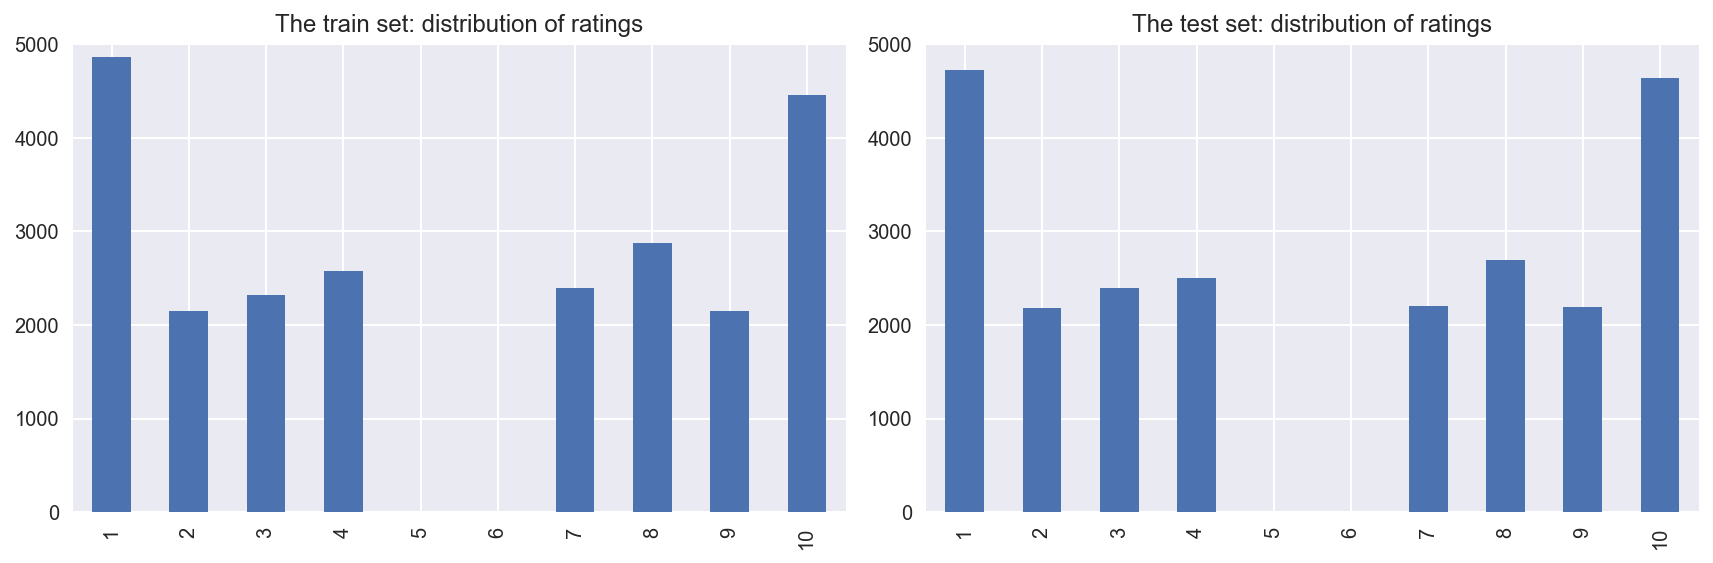

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Notice that the train and test set rating distributions are pretty similiar, so we can proceed with training.

Distribution of negative and positive reviews over the years for two parts of the dataset

C:\Users\dsaad\anaconda3\New folder\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\dsaad\anaconda3\New folder\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\dsaad\anaconda3\New folder\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\dsaad\anaconda3\New folder\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


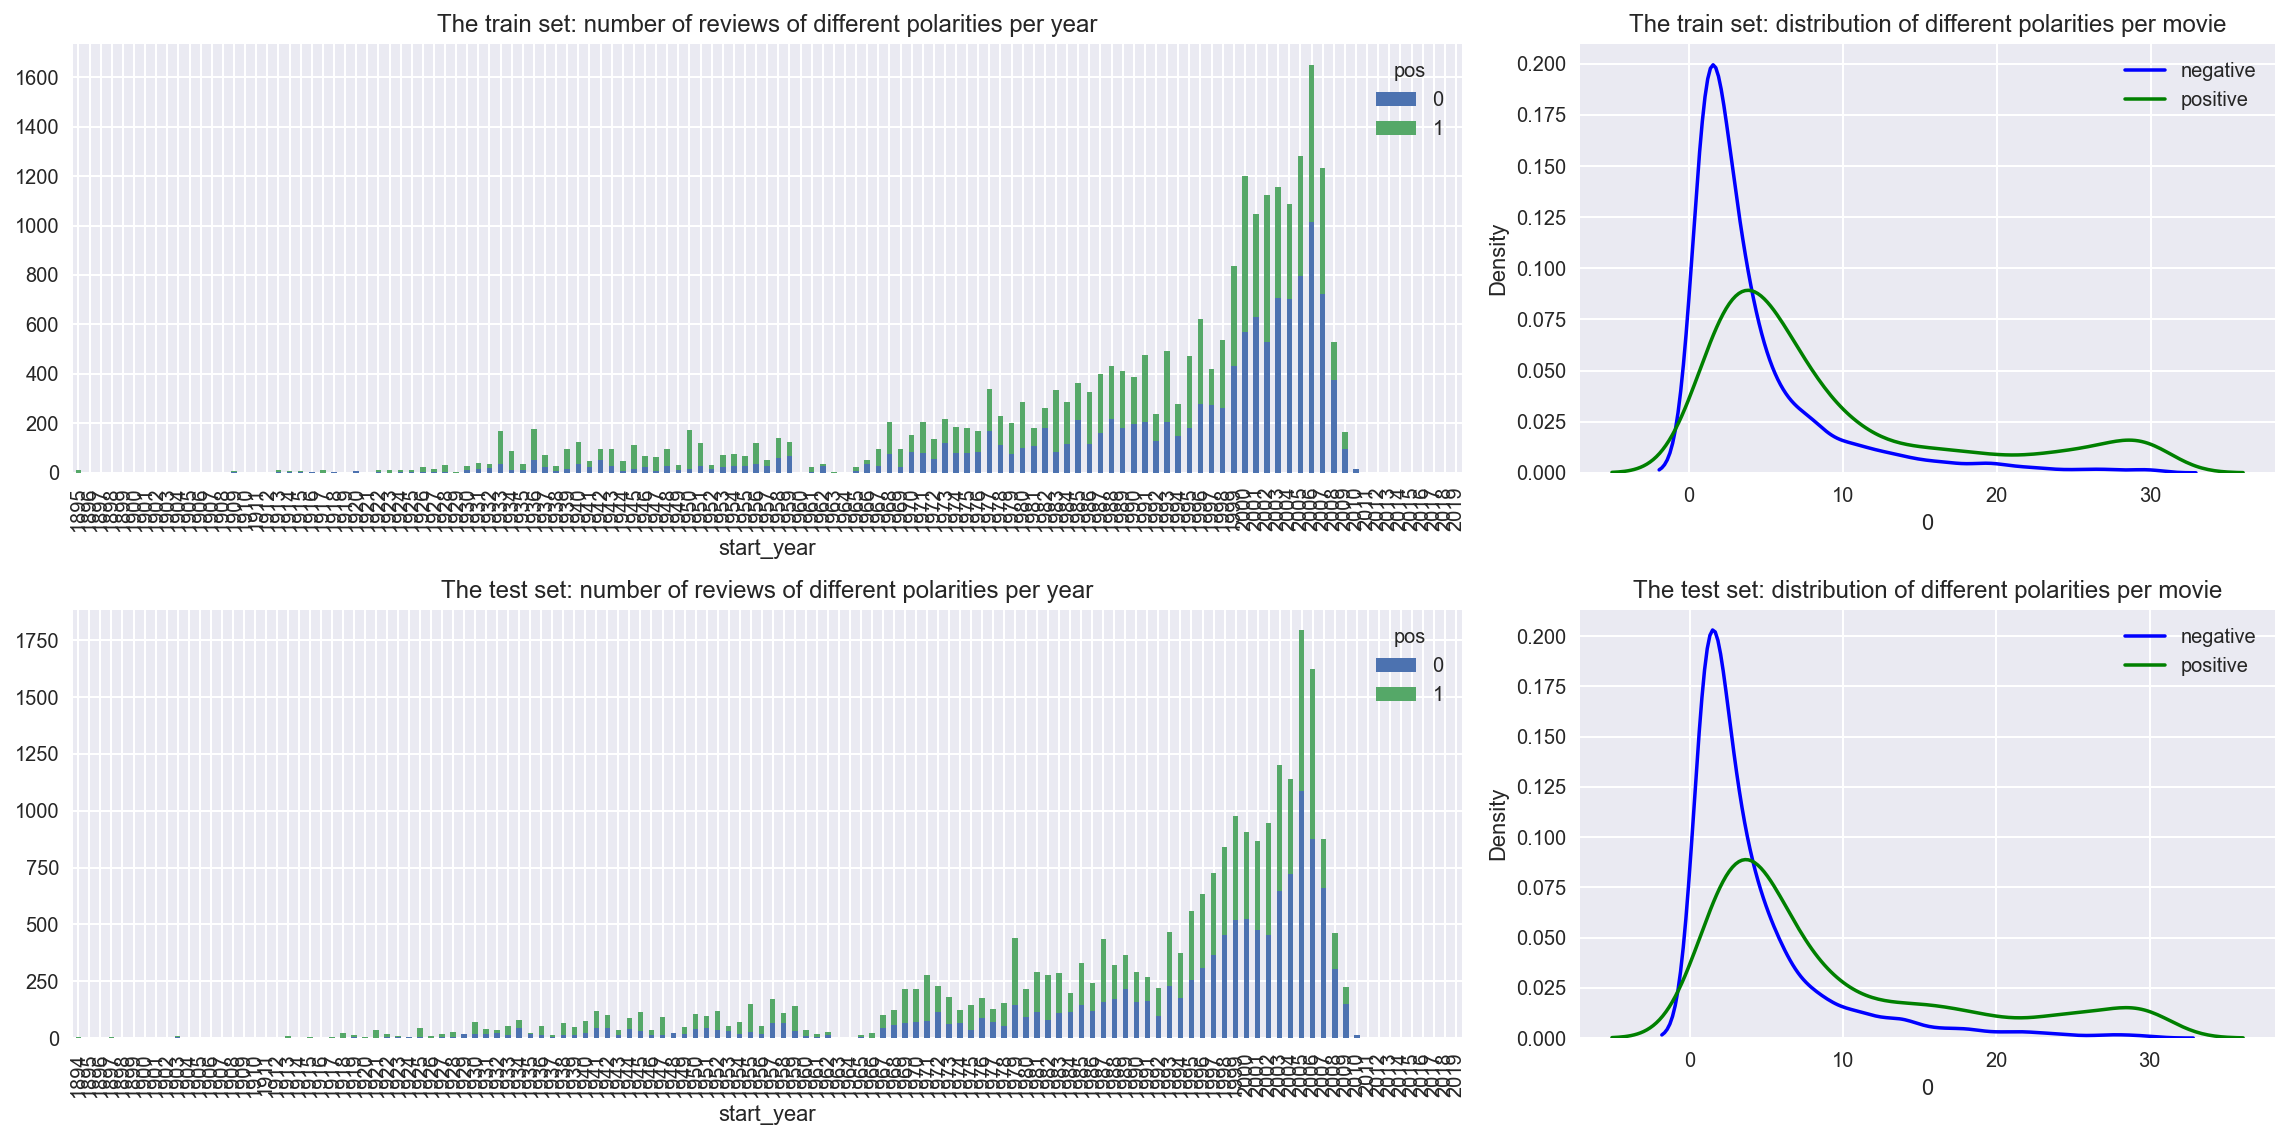

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

It is important to note that over the years, we observe a over increase in both positive and nevative reviews, especially in the early 2000s-2009 in both th train and test sets. Negative ratings are highly concentrated from the 0-10 range. Again, we note that the train and test set have similar distributions.


<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you explored the data and made some interesting observations!

</div>

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [14]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [15]:
df_reviews['review']

0        The pakage implies that Warren Beatty and Gold...
1        How the hell did they get this made?! Presenti...
2        There is no real story the film seems more lik...
3        Um .... a serious film about troubled teens in...
4        I'm totally agree with GarryJohal from Singapo...
                               ...                        
47326    This is another of my favorite Columbos. It sp...
47327    Talk about being boring! I got this expecting ...
47328    I never thought I'd say this about a biopic, b...
47329    Spirit and Chaos is an artistic biopic of Miya...
47330    I'll make this brief. This was a joy to watch....
Name: review, Length: 47329, dtype: object

In [16]:
def clear_text(text):
    pattern = r"[^a-zA-Z']"
    text = re.sub(pattern, ' ', text.lower())
    text = text.split()
    text = " ".join(text)
    return text

In [17]:
df_reviews['review_norm'] = df_reviews['review'].apply(clear_text)

In [18]:
df_reviews['review_norm'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i'm totally agree with garryjohal from singapo...
Name: review_norm, dtype: object

In [19]:
df_reviews['review_norm']

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made presenting...
2        there is no real story the film seems more lik...
3        um a serious film about troubled teens in sing...
4        i'm totally agree with garryjohal from singapo...
                               ...                        
47326    this is another of my favorite columbos it spo...
47327    talk about being boring i got this expecting a...
47328    i never thought i'd say this about a biopic bu...
47329    spirit and chaos is an artistic biopic of miya...
47330    i'll make this brief this was a joy to watch i...
Name: review_norm, Length: 47329, dtype: object

The data is ready for model training.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Normalization looks good!

</div>

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [20]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']
train_features=df_reviews_train['review_norm']
test_features=df_reviews_test['review_norm']

print(df_reviews_train.shape)
print(df_reviews_test.shape)
print(test_features.shape)
print(train_features.shape)
print(train_target.shape)
print(test_target.shape)

(23796, 18)
(23533, 18)
(23533,)
(23796,)
(23796,)
(23533,)


## Working with models

### Model 0 - Constant

In [21]:
from sklearn.dummy import DummyClassifier

In [22]:
model_0 = DummyClassifier(strategy='constant', constant=1)
model_0.fit(train_features, train_target)

DummyClassifier(constant=1, strategy='constant')

          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


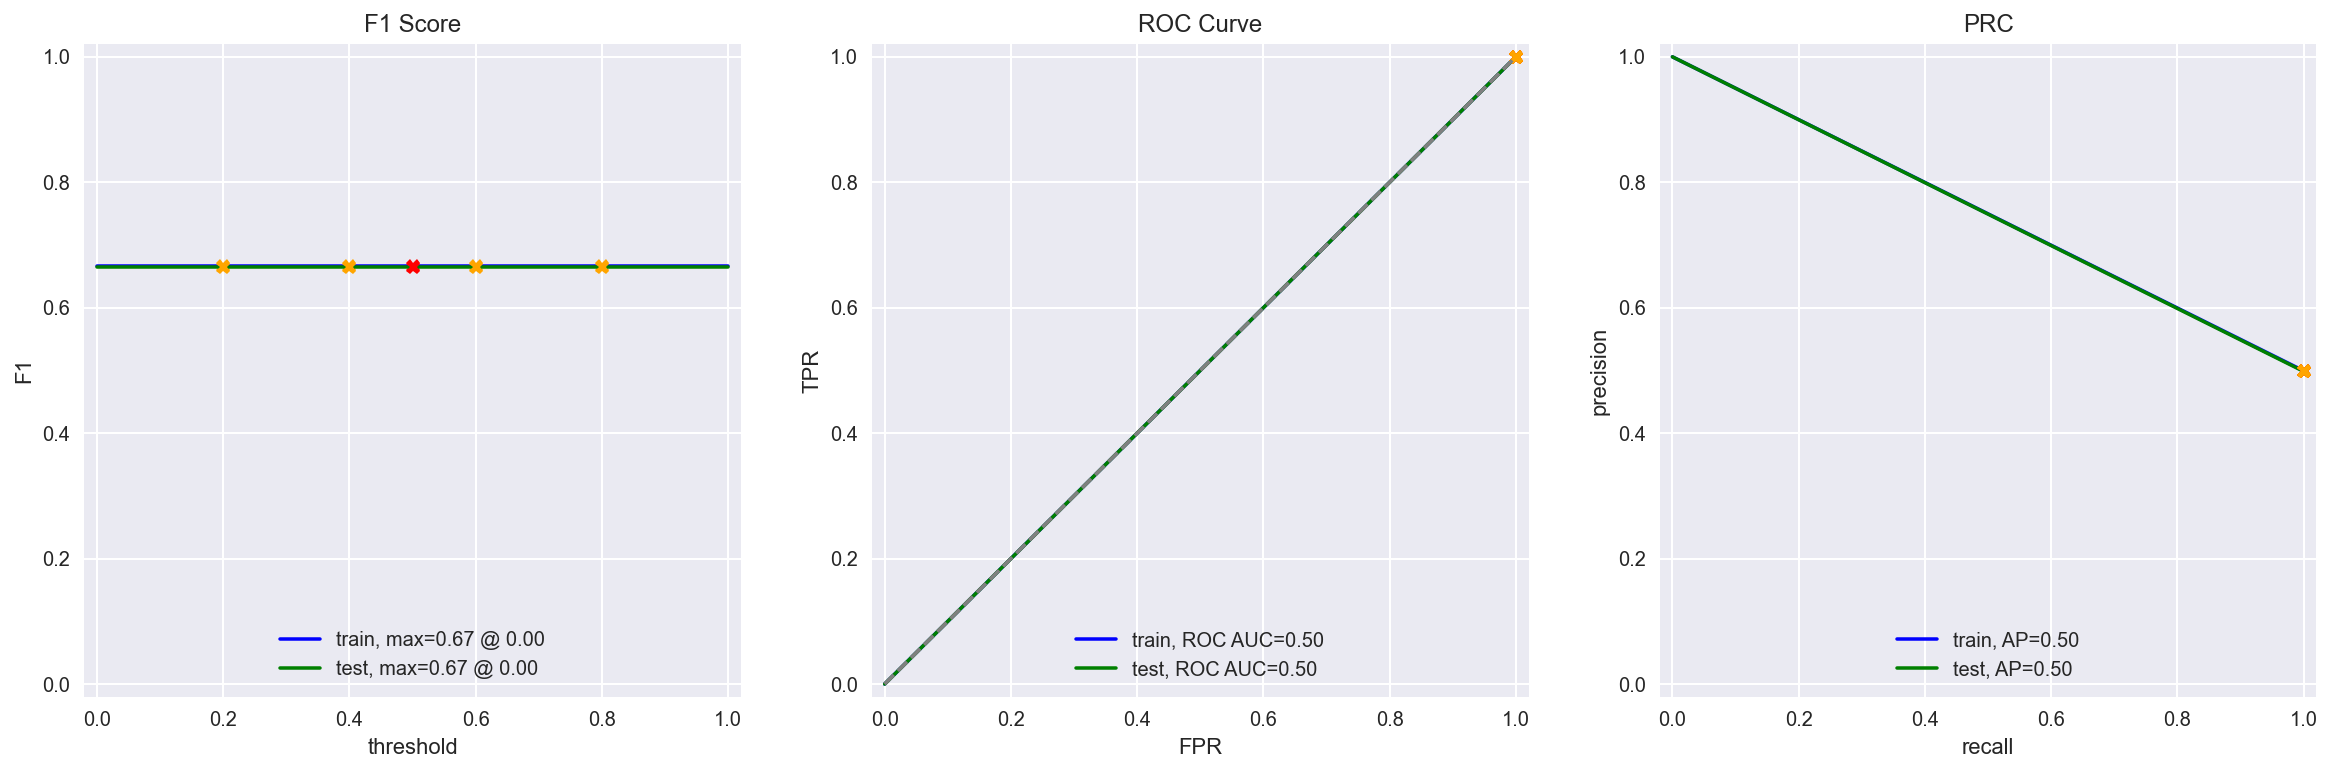

In [23]:
model_0_eval= evaluate_model(model_0, train_features, train_target, test_features, test_target)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Ok, there's a baseline!

</div>

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [24]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dsaad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:


stop_words = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words) 
train_tf_idf =count_tf_idf.fit_transform(train_features) 
test_tf_idf =count_tf_idf.transform(test_features) 
print(train_tf_idf.shape)
print(test_tf_idf.shape)

(23796, 71531)
(23533, 71531)


In [26]:
type(train_tf_idf)
dir(train_tf_idf)

['__abs__',
 '__add__',
 '__array_priority__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__idiv__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__pow__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmatmul__',
 '__rmul__',
 '__round__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_add_dense',
 '_add_sparse',
 '_arg_min_or_max',
 '_arg_min_or_max_axis',
 '_asindices',
 '_binopt',
 '_cs_matrix__get_has_canonical_format',
 '_cs_matrix__get_sorted',
 '_cs_matrix__set_has_canonical_format',
 '_cs_matr

In [27]:
#use train_tf_idf in place of train_features because this makes it numeric, train_target is already numeric
model_1=LogisticRegression(random_state=12345, solver='liblinear')
model_1.fit(train_tf_idf, train_target)


LogisticRegression(random_state=12345, solver='liblinear')

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


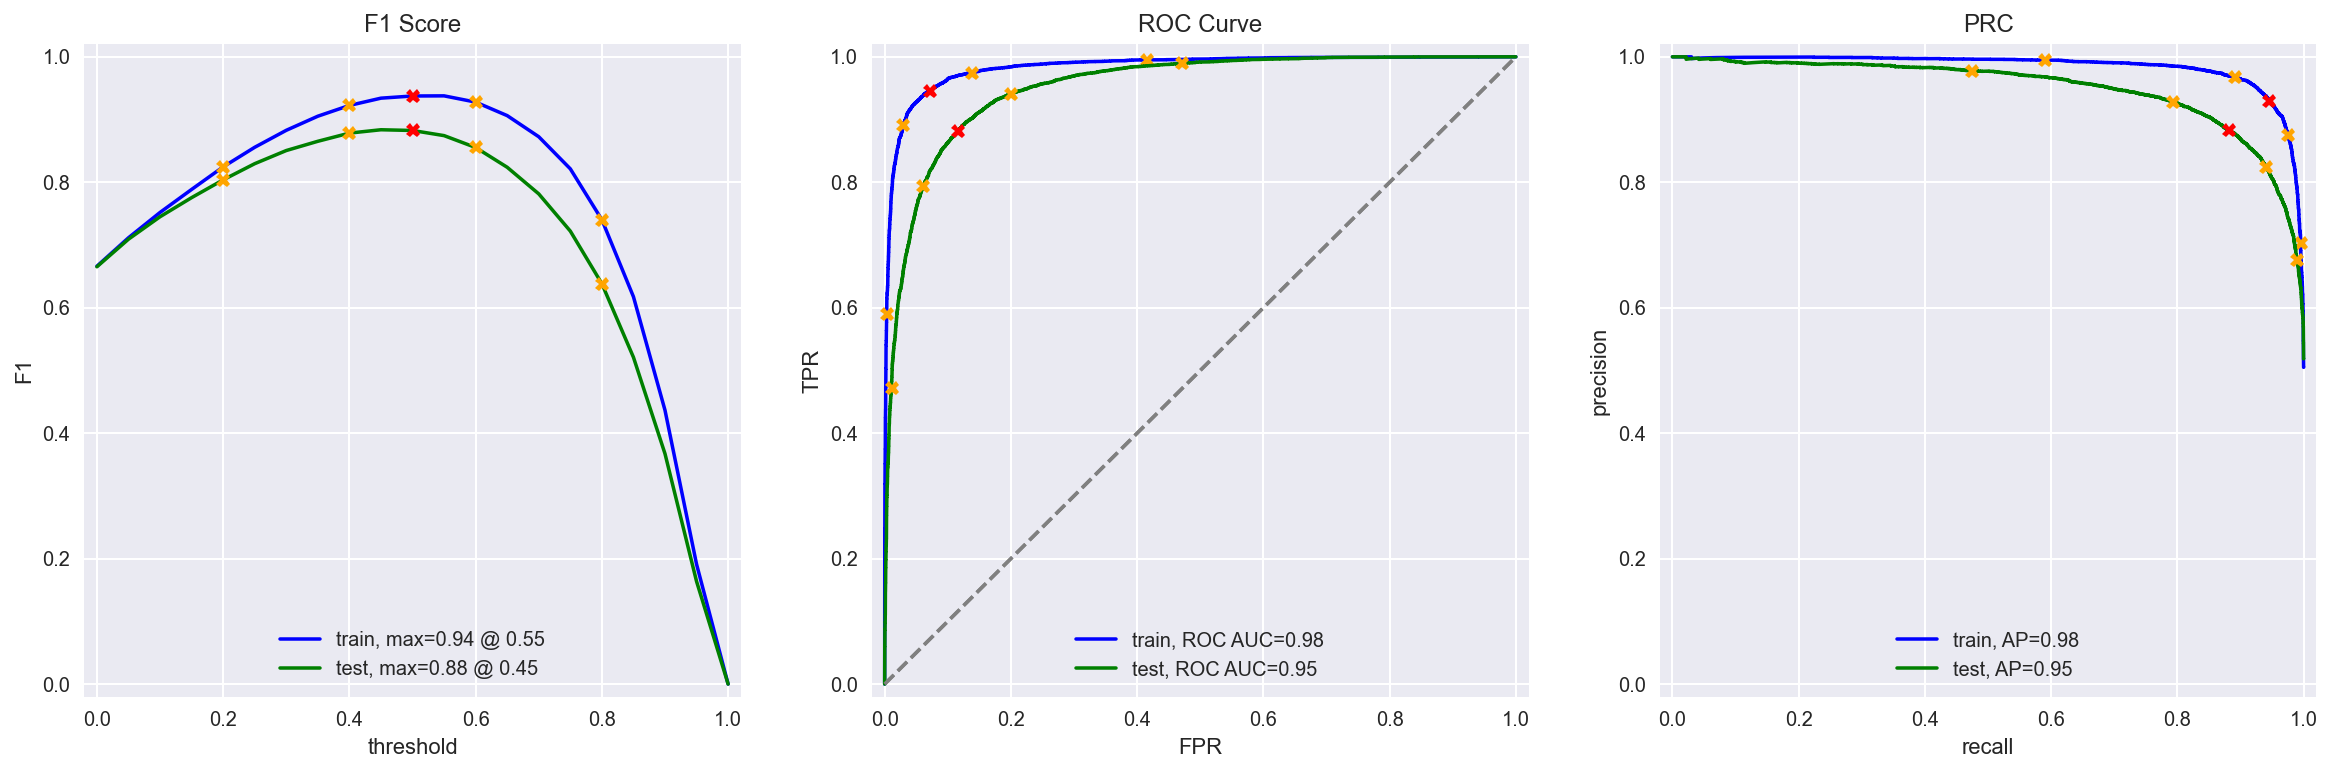

In [28]:
evaluate_model(model_1, train_tf_idf, train_target, test_tf_idf, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [29]:
!pip install spacy


In [30]:
import spacy
!python -m spacy download en_core_web_sm 
from spacy import displacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

2022-12-07 20:18:31.594435: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-12-07 20:18:31.594504: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-07 20:18:39.455697: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2022-12-07 20:18:39.455733: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-07 20:18:39.459970: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: DESKTOP-GF0K1ER
2022-12-07 20:18:39.460090: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: DESKTOP-GF0K1ER


  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 3.4.0
    Uninstalling en-core-web-sm-3.4.0:
      Successfully uninstalled en-core-web-sm-3.4.0
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [31]:
#Before preprocessing
#df_reviews['review']

In [32]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [33]:
def lemmatize(text):

    doc = nlp(text)
    
    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
        
    return ' '.join(lemmas)

In [34]:
df_reviews['reviews_lemm'] = df_reviews['review'].progress_apply(lemmatize)

  0%|          | 0/47329 [00:00<?, ?it/s]

In [35]:
df_reviews['reviews_lemm']

0        the pakage imply that Warren Beatty and Goldie...
1        how the hell do they get this make ? ! present...
2        there be no real story the film seem more like...
3        um .... a serious film about troubled teen in ...
4        I be totally agree with GarryJohal from Singap...
                               ...                        
47326    this be another of my favorite columbo . it sp...
47327    talk about be boring ! I get this expect a fas...
47328    I never think I would say this about a biopic ...
47329    Spirit and Chaos be an artistic biopic of Miya...
47330    I will make this brief . this be a joy to watc...
Name: reviews_lemm, Length: 47329, dtype: object

In [36]:
features_train = df_reviews.query('ds_part == "train"')['reviews_lemm']
features_test = df_reviews.query('ds_part == "test"')['reviews_lemm']
print(features_train.shape)
print(features_test.shape)

(23796,)
(23533,)


In [37]:
count_tf_idf_lemm = TfidfVectorizer(stop_words=stop_words)
tfidf_train_lemm = count_tf_idf_lemm.fit_transform(features_train)
tfidf_test_lemm = count_tf_idf_lemm.transform(features_test)

In [38]:
model_3=LogisticRegression()
model_3.fit(tfidf_train_lemm, train_target)


LogisticRegression()

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


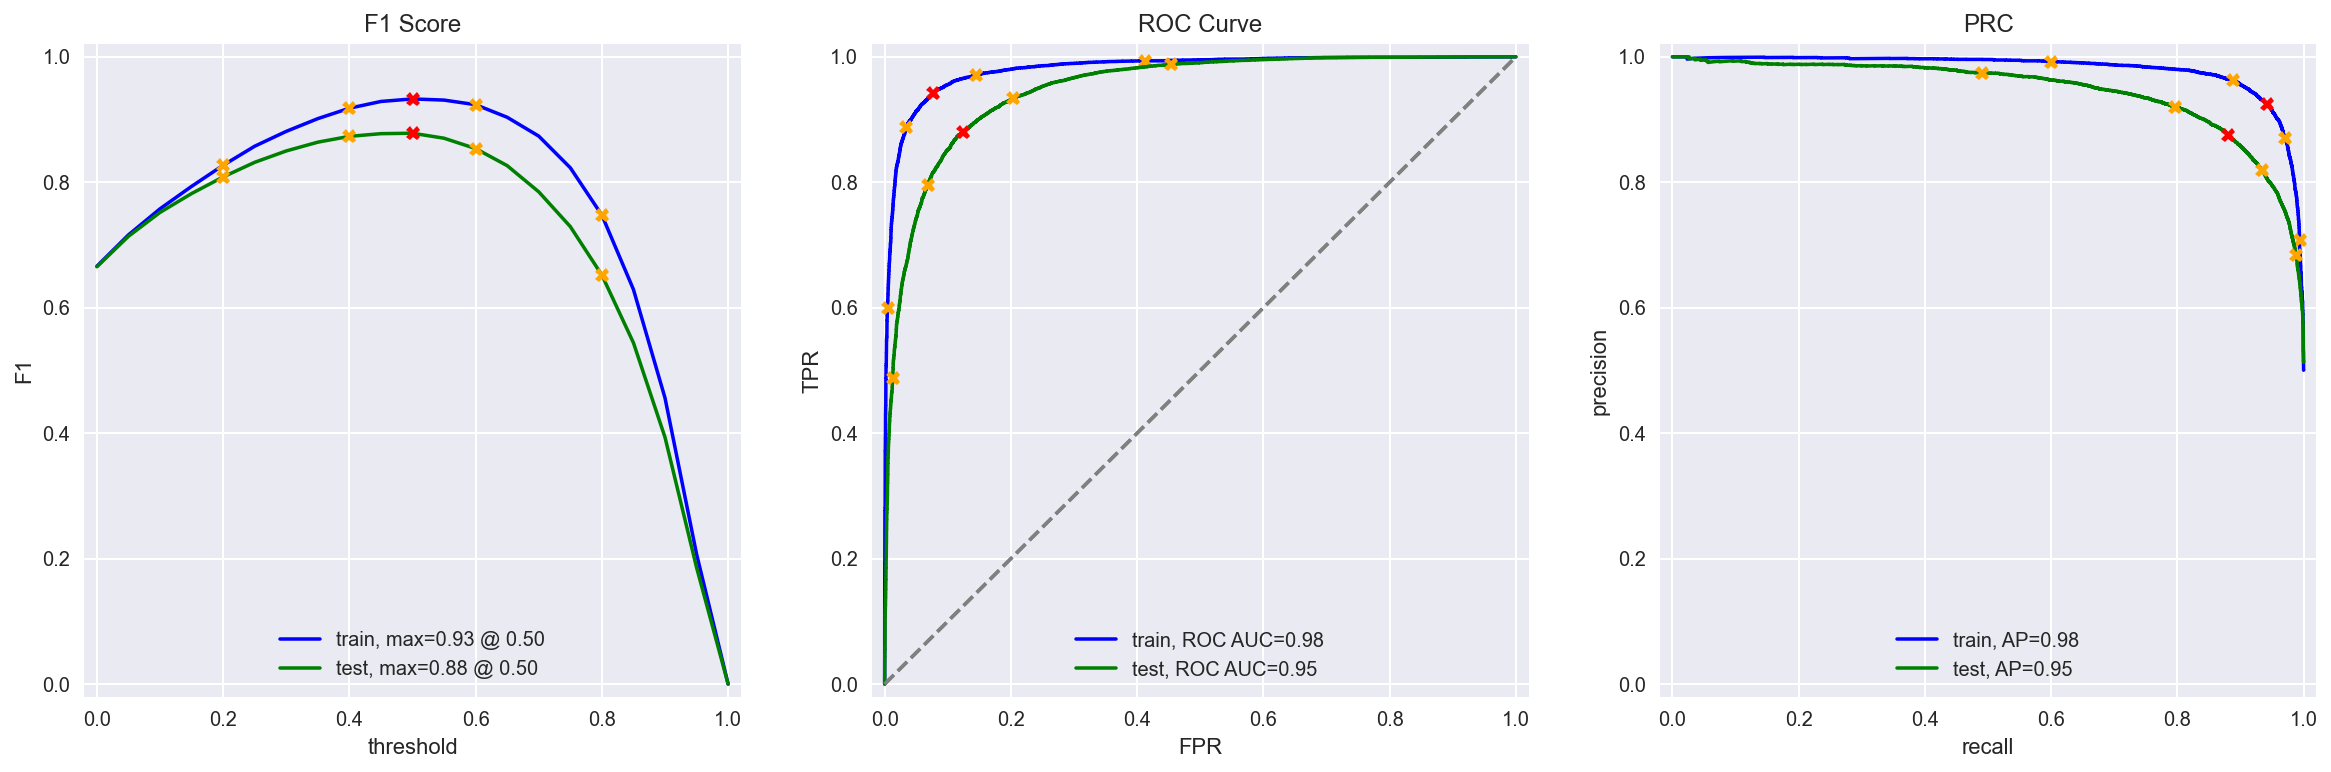

In [39]:
evaluate_model(model_3, tfidf_train_lemm, train_target, tfidf_test_lemm, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [40]:
!pip install lightgbm

In [41]:
from lightgbm import LGBMClassifier

In [42]:
model_4=LGBMClassifier(random_state=12345)
model_4.fit(tfidf_train_lemm, train_target)

LGBMClassifier(random_state=12345)

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


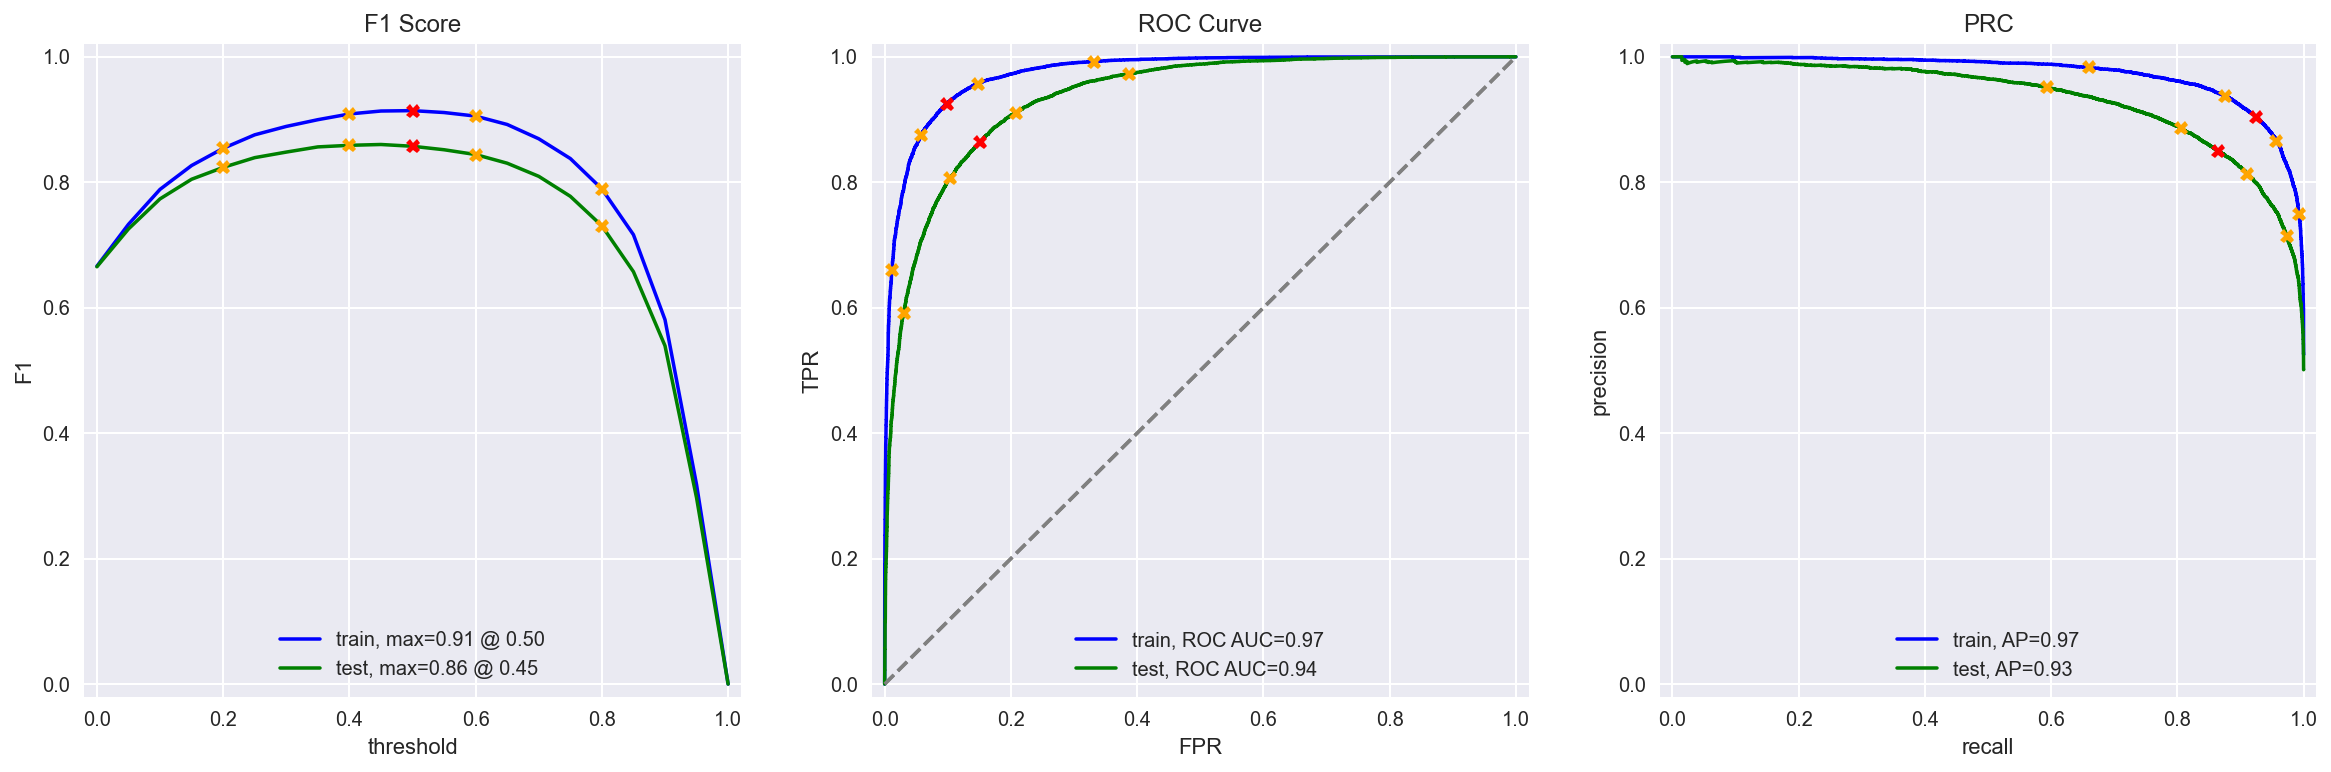

In [43]:
evaluate_model(model_4, tfidf_train_lemm, train_target, tfidf_test_lemm, test_target)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you successfully vectorized text data using TF-IDF and trained a couple of models using the resulting features

</div>

###  Model 9 - BERT -Not Attempted

<div class="alert alert-success">
<b>Reviewer's comment</b>

Ok!

</div>

In [47]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    #ids = tokenizer.encode(texts, add_special_tokens=True)
    #text=df_reviews['review']
  <put your code here to create ids_list and attention_mask_list>
    ids_list = []
    for id in ids:
        ids = df_reviews['review_norm'].apply(
  lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512))
        ids_list.append(ids)
    attention_mask_list = []
    for item in attention_mask:
        attention_mask_list.append(item)

      text to padded ids of tokens along with their attention masks
    padded = np.array(ids[:n] + [0]*(n - len(ids)))
    attention_mask = np.where(padded != 0, 1, 0)
    
    if force_device is not None:
        #device = torch.device(force_device)
    else:
        #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        #print(f'Using the {device} device.')
    
     gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
         <put your code here to create attention_mask_batch
        attention_mask_batch= torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [48]:
df_reviews_train['review_norm'].sample(100)

In [49]:
 Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_9 = BERT_text_to_embeddings(list(df_reviews_train['review_norm']), force_device='cuda')

## My Reviews

In [52]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: clear_text(x))

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 2

In [53]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(count_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn't expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 3

In [54]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(count_tf_idf_lemm.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.48:  i was really fascinated with the movie
0.13:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26:  i didn't expect the reboot to be so good writers really cared about the source material
0.49:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


In [55]:
prop_error= 1 / 8
print(f'{"Error Proportion for Model 3"}: {prop_error}')

Error Proportion for Model 3: 0.125


### Model 4

In [56]:
texts = my_reviews['review_norm']

#tfidf_vectorizer_4 = count_tf_idf_lemm
my_reviews_pred_prob = model_4.predict_proba(count_tf_idf_lemm.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')


0.61:  i did not simply like it not my kind of movie
0.44:  well i was bored and felt asleep in the middle of the movie
0.60:  i was really fascinated with the movie
0.34:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.62:  i didn't expect the reboot to be so good writers really cared about the source material
0.68:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.26:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.78:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


In [57]:
prop_error= 1 / 8
print(f'{"Error Proportion for Model 4"}: {prop_error}')

Error Proportion for Model 4: 0.125


### Model 9

## Conclusions

* The goal of this project was to build different models to detect negative reviews in a set of movie reviews. Because the data was already split into training and testing parts, there was no need to manipulate the data any further. 
* As for data preprocessing, we did remove 2 rows total that contained missing values.

* Due to lack of computing power, the BERT model was not attempted in this project.

* The following models which were trained and tested included: Model 0 (constant model), 1, 3, and 4. Model 1 utilized NLTK, TF-IDF and LR. Model 3 utilized spaCy, TF-IDF and LR. Finally, Model 4 utilized spaCy, TF-IDF and LGBMClassifier. 

    The results were as follows:

| Model | Data | Accuracy | F1 Score
| --- | --- | --- | ---  |
| Model 0 | Train | .50 | .67
|  --- | --- | --- | --- |
| Model 0 | Test | .50 |  .67
|  --- | --- | --- | --- |
| Model 1 | Train | .94 | .94
|  --- | --- | --- | --- |
| Model 1 | Test | .88 |  .88
|  --- | --- | --- | --- |
| Model 3 | Train | .93 | .93
|  --- | --- | --- | --- |
| Model 3 | Test | .88 | .88
|  --- | --- | --- | --- |
| Model 4 | Train | .91 | .91
|  --- | --- | --- | --- |
| Model 4 | Test | .86 | .86

* As we see in the chart above, Models 1, 3 and 4 all performed better (in accuracy and F1 Score) as compared to the dummy model, which is to be expected. All models resulted in an F1 Score which exceeded the desired threshold of 0.85. 

* We note that each model's inflection point is assumed to be 0.5 since these models were LR-absed. So, when we evaluated the sample reviews in "My Reviews" based on each model, we found that for the most part, if the model predicted a probability of <.50, it detected a negative review and if it predicted a probability of >.50, it detected a positive review. We note that from a total of 8 sample reviews, Model 1 performed the worst as it incorrectly categorized 25% of reviews, whereas Model 3 and 4 had an accuracy error of 12.5%.
* This is interesting to note as we obeserved Model 1 performed the best in the much larger sample of 47,329 reviews as compared to the other two models. We might be able to attribute this difference to chance or it could possibly be due to how the data was partitioned into equal parts.
* It also might be considerable to determine the quality of text in each review to ensure sentiment balance.